<a href="https://colab.research.google.com/github/NahidurRahaman/Machine_Learning/blob/main/Facial_Emotion_detection_using_MLP_CNN_CNNBN_ResNet(CK%2B).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports and Augmentation**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


**FER2013 Custom Dataset Loader**

In [ ]:
class FER2013Dataset(Dataset):
    def __init__(self, csv_file, usage='Training', transform=None):
        self.data = pd.read_csv(csv_file)
        self.data = self.data[self.data['Usage'] == usage]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = np.array(self.data.iloc[idx]['pixels'].split(), dtype='float32')
        image = pixels.reshape(48, 48)
        image = Image.fromarray(image).convert("L")
        label = int(self.data.iloc[idx]['emotion'])
        if self.transform:
            image = self.transform(image)
        return image, label


**Model 1: MLP**

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        # Corrected input size for the first linear layer (1*48*48 = 2304)
        self.fc1 = nn.Linear(48*48, 1024)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 256)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(256, 128)
        self.relu4 = nn.ReLU()
        # Corrected output size for the last linear layer (7 classes)
        self.fc5 = nn.Linear(128, 7)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        return x

**Model 2: CNN**

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 10 * 10, 128), # Corrected input size to 6400
            nn.ReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

**Model 3: CNN + BatchNorm**

In [ ]:
class CNN_BN(nn.Module):
    def __init__(self):
        super(CNN_BN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3),               # -> [32, 46, 46]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                   # -> [32, 23, 23]

            nn.Conv2d(32, 64, 3),              # -> [64, 21, 21]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)                    # -> [64, 10, 10]
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 10 * 10, 128),      # ✅ Update shape here: 6400
            nn.ReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        # print(x.shape)  # Uncomment this line to debug shape
        return self.fc_layers(x)


**Model 4: Transfer Learning (ResNet18)**

In [ ]:
class ResNetTransfer(nn.Module):
    def __init__(self):
        super(ResNetTransfer, self).__init__()
        base_model = models.resnet18(pretrained=True)
        base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_features = base_model.fc.in_features
        base_model.fc = nn.Linear(num_features, 7)
        self.model = base_model

    def forward(self, x):
        return self.model(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1 = MLP().to(device)  # পরিবর্তন করুন অন্য মডেল অনুযায়ী: MLP(), CNN(), ResNetTransfer()

optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


**Training and Validation Loop**

In [ ]:
def train(model, loader, optimizer, criterion):
    model_1.train()
    total_loss, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def validate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item()
            correct += (pred.argmax(1) == y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Dataset Load and Train**

In [ ]:
train_dataset = FER2013Dataset("/content/drive/MyDrive/FER2013/ckextended.csv", usage='Training', transform=transform_train)
val_dataset = FER2013Dataset("/content/drive/MyDrive/FER2013/ckextended.csv", usage='PublicTest', transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(50):
    train_loss, train_acc = train(model_1, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model_1, val_loader, criterion)

    # Append metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}")

Epoch 1: Train Acc=0.60, Val Acc=0.66
Epoch 2: Train Acc=0.66, Val Acc=0.66
Epoch 3: Train Acc=0.66, Val Acc=0.66
Epoch 4: Train Acc=0.69, Val Acc=0.73
Epoch 5: Train Acc=0.75, Val Acc=0.82
Epoch 6: Train Acc=0.80, Val Acc=0.75
Epoch 7: Train Acc=0.78, Val Acc=0.78
Epoch 8: Train Acc=0.81, Val Acc=0.83
Epoch 9: Train Acc=0.82, Val Acc=0.81
Epoch 10: Train Acc=0.82, Val Acc=0.85
Epoch 11: Train Acc=0.86, Val Acc=0.84
Epoch 12: Train Acc=0.86, Val Acc=0.85
Epoch 13: Train Acc=0.88, Val Acc=0.85
Epoch 14: Train Acc=0.89, Val Acc=0.85
Epoch 15: Train Acc=0.88, Val Acc=0.84
Epoch 16: Train Acc=0.89, Val Acc=0.85
Epoch 17: Train Acc=0.89, Val Acc=0.87
Epoch 18: Train Acc=0.90, Val Acc=0.87
Epoch 19: Train Acc=0.90, Val Acc=0.84
Epoch 20: Train Acc=0.91, Val Acc=0.85
Epoch 21: Train Acc=0.90, Val Acc=0.84
Epoch 22: Train Acc=0.90, Val Acc=0.84
Epoch 23: Train Acc=0.91, Val Acc=0.84
Epoch 24: Train Acc=0.90, Val Acc=0.84
Epoch 25: Train Acc=0.90, Val Acc=0.84
Epoch 26: Train Acc=0.90, Val Acc=

**Plot Accuracy & Loss**

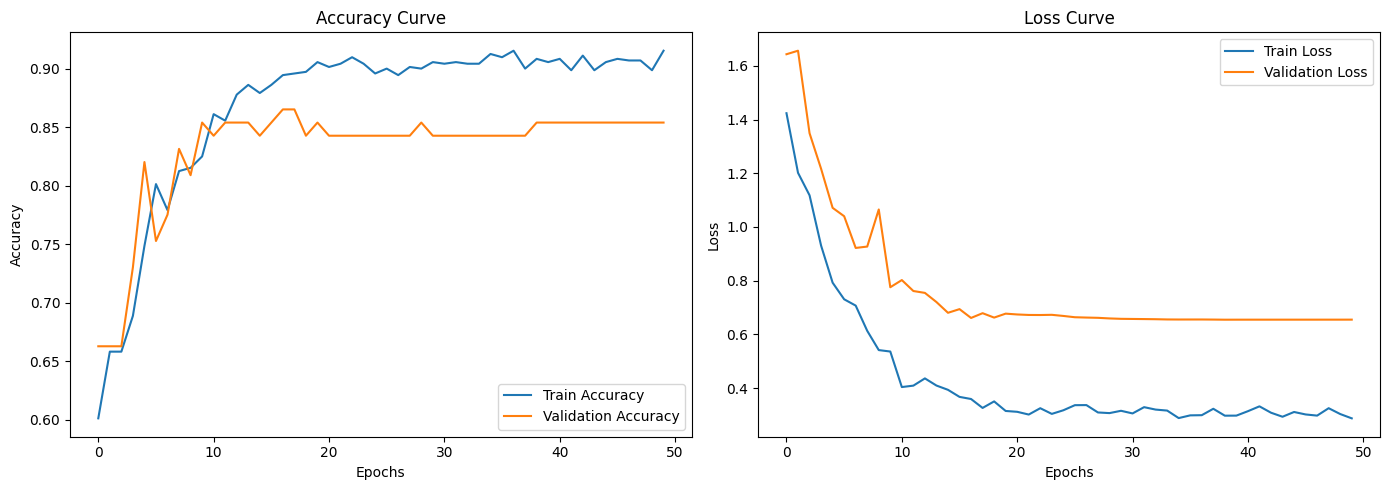

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()


**Confusion Matrix & Classification Report**

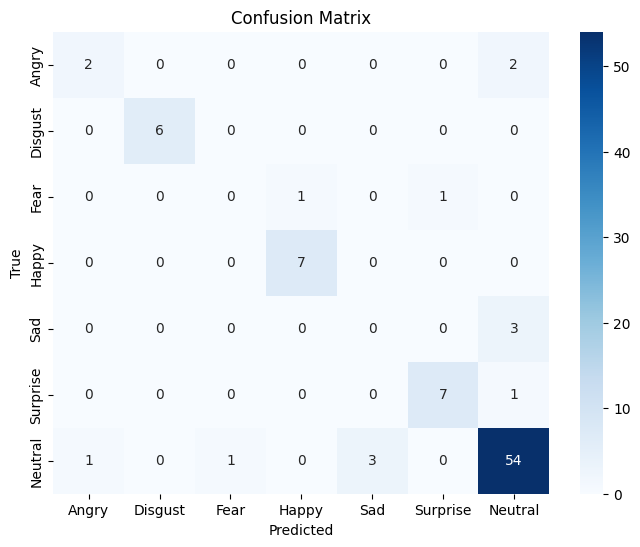

              precision    recall  f1-score   support

       Angry       0.67      0.50      0.57         4
     Disgust       1.00      1.00      1.00         6
        Fear       0.00      0.00      0.00         2
       Happy       0.88      1.00      0.93         7
         Sad       0.00      0.00      0.00         3
    Surprise       0.88      0.88      0.88         8
     Neutral       0.90      0.92      0.91        59

    accuracy                           0.85        89
   macro avg       0.62      0.61      0.61        89
weighted avg       0.84      0.85      0.85        89



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Make predictions
all_preds = []
all_labels = []

model_1.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_1(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=emotion_labels))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2 = CNN().to(device)  # পরিবর্তন করুন অন্য মডেল অনুযায়ী: MLP(), CNN(), ResNetTransfer()

optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
train_dataset = FER2013Dataset("/content/drive/MyDrive/FER2013/ckextended.csv", usage='Training', transform=transform_train)
val_dataset = FER2013Dataset("/content/drive/MyDrive/FER2013/ckextended.csv", usage='PublicTest', transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()
# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(50):
    train_loss, train_acc = train(model_2, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model_2, val_loader, criterion)

    # Append metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}")

Epoch 1: Train Acc=0.62, Val Acc=0.66
Epoch 2: Train Acc=0.66, Val Acc=0.66
Epoch 3: Train Acc=0.66, Val Acc=0.67
Epoch 4: Train Acc=0.70, Val Acc=0.78
Epoch 5: Train Acc=0.78, Val Acc=0.76
Epoch 6: Train Acc=0.81, Val Acc=0.88
Epoch 7: Train Acc=0.86, Val Acc=0.84
Epoch 8: Train Acc=0.85, Val Acc=0.88
Epoch 9: Train Acc=0.88, Val Acc=0.85
Epoch 10: Train Acc=0.87, Val Acc=0.89
Epoch 11: Train Acc=0.90, Val Acc=0.88
Epoch 12: Train Acc=0.90, Val Acc=0.88
Epoch 13: Train Acc=0.91, Val Acc=0.88
Epoch 14: Train Acc=0.92, Val Acc=0.88
Epoch 15: Train Acc=0.92, Val Acc=0.88
Epoch 16: Train Acc=0.91, Val Acc=0.88
Epoch 17: Train Acc=0.91, Val Acc=0.88
Epoch 18: Train Acc=0.90, Val Acc=0.88
Epoch 19: Train Acc=0.92, Val Acc=0.88
Epoch 20: Train Acc=0.91, Val Acc=0.88
Epoch 21: Train Acc=0.92, Val Acc=0.88
Epoch 22: Train Acc=0.92, Val Acc=0.88
Epoch 23: Train Acc=0.92, Val Acc=0.88
Epoch 24: Train Acc=0.92, Val Acc=0.88
Epoch 25: Train Acc=0.92, Val Acc=0.88
Epoch 26: Train Acc=0.92, Val Acc=

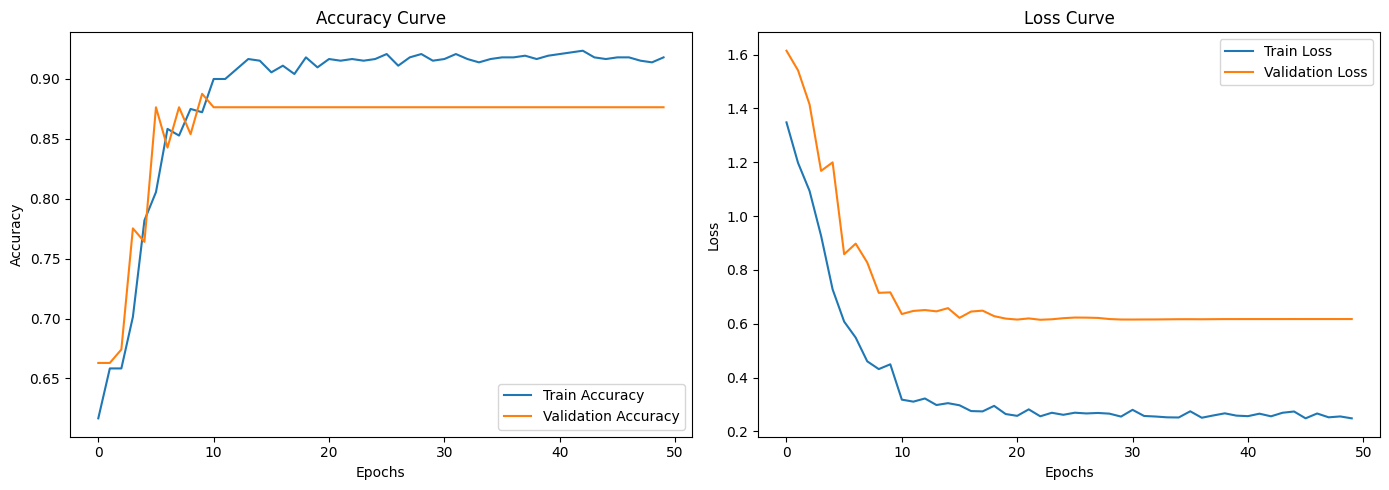

In [ ]:
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()


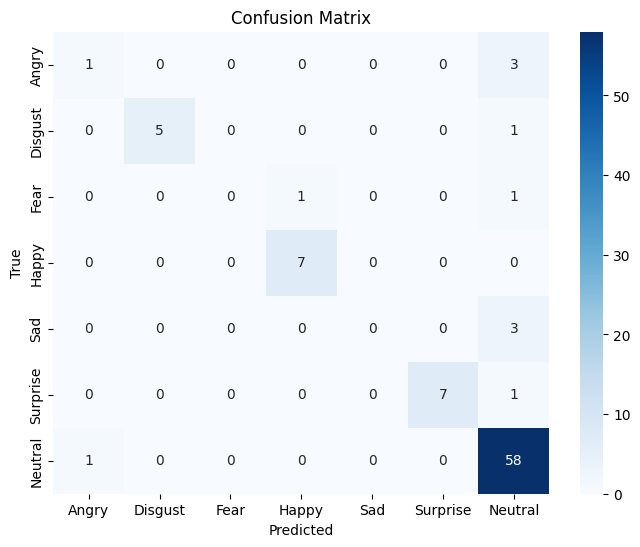

              precision    recall  f1-score   support

       Angry       0.50      0.25      0.33         4
     Disgust       1.00      0.83      0.91         6
        Fear       0.00      0.00      0.00         2
       Happy       0.88      1.00      0.93         7
         Sad       0.00      0.00      0.00         3
    Surprise       1.00      0.88      0.93         8
     Neutral       0.87      0.98      0.92        59

    accuracy                           0.88        89
   macro avg       0.61      0.56      0.58        89
weighted avg       0.82      0.88      0.84        89



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
# Make predictions
all_preds = []
all_labels = []

model_2.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_2(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=emotion_labels))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3 = CNN_BN().to(device)  # পরিবর্তন করুন অন্য মডেল অনুযায়ী: MLP(), CNN(), ResNetTransfer()

optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
train_dataset = FER2013Dataset("/content/drive/MyDrive/FER2013/ckextended.csv", usage='Training', transform=transform_train)
val_dataset = FER2013Dataset("/content/drive/MyDrive/FER2013/ckextended.csv", usage='PublicTest', transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()
# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(50):
    train_loss, train_acc = train(model_3, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model_3, val_loader, criterion)

    # Append metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}")

Epoch 1: Train Acc=0.59, Val Acc=0.66
Epoch 2: Train Acc=0.66, Val Acc=0.67
Epoch 3: Train Acc=0.68, Val Acc=0.71
Epoch 4: Train Acc=0.72, Val Acc=0.75
Epoch 5: Train Acc=0.77, Val Acc=0.80
Epoch 6: Train Acc=0.81, Val Acc=0.81
Epoch 7: Train Acc=0.83, Val Acc=0.84
Epoch 8: Train Acc=0.84, Val Acc=0.88
Epoch 9: Train Acc=0.86, Val Acc=0.89
Epoch 10: Train Acc=0.89, Val Acc=0.88
Epoch 11: Train Acc=0.90, Val Acc=0.88
Epoch 12: Train Acc=0.92, Val Acc=0.89
Epoch 13: Train Acc=0.91, Val Acc=0.89
Epoch 14: Train Acc=0.93, Val Acc=0.90
Epoch 15: Train Acc=0.92, Val Acc=0.88
Epoch 16: Train Acc=0.92, Val Acc=0.88
Epoch 17: Train Acc=0.92, Val Acc=0.88
Epoch 18: Train Acc=0.92, Val Acc=0.88
Epoch 19: Train Acc=0.93, Val Acc=0.89
Epoch 20: Train Acc=0.93, Val Acc=0.88
Epoch 21: Train Acc=0.94, Val Acc=0.88
Epoch 22: Train Acc=0.93, Val Acc=0.89
Epoch 23: Train Acc=0.93, Val Acc=0.88
Epoch 24: Train Acc=0.93, Val Acc=0.88
Epoch 25: Train Acc=0.93, Val Acc=0.88
Epoch 26: Train Acc=0.93, Val Acc=

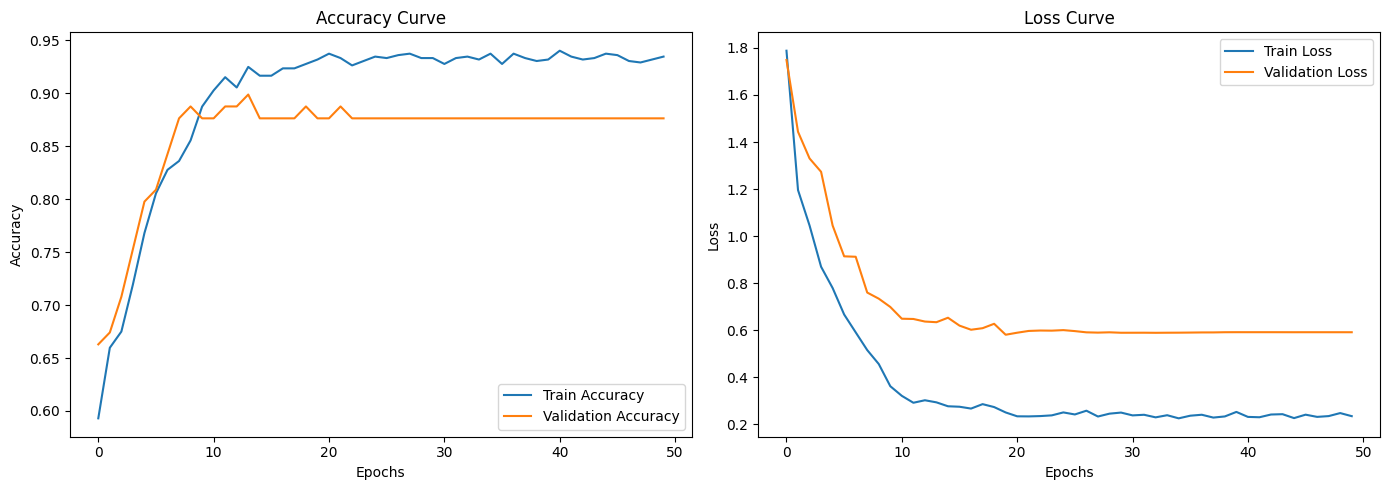

In [ ]:
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()


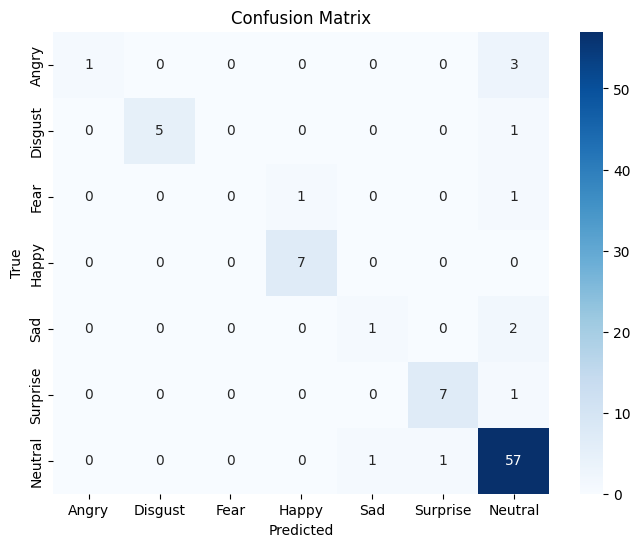

              precision    recall  f1-score   support

       Angry       1.00      0.25      0.40         4
     Disgust       1.00      0.83      0.91         6
        Fear       0.00      0.00      0.00         2
       Happy       0.88      1.00      0.93         7
         Sad       0.50      0.33      0.40         3
    Surprise       0.88      0.88      0.88         8
     Neutral       0.88      0.97      0.92        59

    accuracy                           0.88        89
   macro avg       0.73      0.61      0.63        89
weighted avg       0.86      0.88      0.85        89



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Make predictions
all_preds = []
all_labels = []

model_3.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_3(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=emotion_labels))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_4 = ResNetTransfer().to(device)  # পরিবর্তন করুন অন্য মডেল অনুযায়ী: MLP(), CNN(), ResNetTransfer()

optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_dataset = FER2013Dataset("/content/drive/MyDrive/FER2013/ckextended.csv", usage='Training', transform=transform_train)
val_dataset = FER2013Dataset("/content/drive/MyDrive/FER2013/ckextended.csv", usage='PublicTest', transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

criterion = nn.CrossEntropyLoss()

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(50):
    train_loss, train_acc = train(model_4, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model_4, val_loader, criterion)

    # Append metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}")

Epoch 1: Train Acc=0.63, Val Acc=0.64
Epoch 2: Train Acc=0.66, Val Acc=0.66
Epoch 3: Train Acc=0.66, Val Acc=0.66
Epoch 4: Train Acc=0.66, Val Acc=0.66
Epoch 5: Train Acc=0.66, Val Acc=0.66
Epoch 6: Train Acc=0.65, Val Acc=0.66
Epoch 7: Train Acc=0.66, Val Acc=0.66
Epoch 8: Train Acc=0.66, Val Acc=0.66
Epoch 9: Train Acc=0.66, Val Acc=0.66
Epoch 10: Train Acc=0.66, Val Acc=0.66
Epoch 11: Train Acc=0.66, Val Acc=0.66
Epoch 12: Train Acc=0.66, Val Acc=0.66
Epoch 13: Train Acc=0.66, Val Acc=0.66
Epoch 14: Train Acc=0.66, Val Acc=0.66
Epoch 15: Train Acc=0.66, Val Acc=0.66
Epoch 16: Train Acc=0.66, Val Acc=0.66
Epoch 17: Train Acc=0.66, Val Acc=0.66
Epoch 18: Train Acc=0.66, Val Acc=0.66
Epoch 19: Train Acc=0.66, Val Acc=0.66
Epoch 20: Train Acc=0.66, Val Acc=0.66
Epoch 21: Train Acc=0.66, Val Acc=0.66
Epoch 22: Train Acc=0.66, Val Acc=0.66
Epoch 23: Train Acc=0.66, Val Acc=0.66
Epoch 24: Train Acc=0.66, Val Acc=0.66
Epoch 25: Train Acc=0.66, Val Acc=0.66
Epoch 26: Train Acc=0.66, Val Acc=

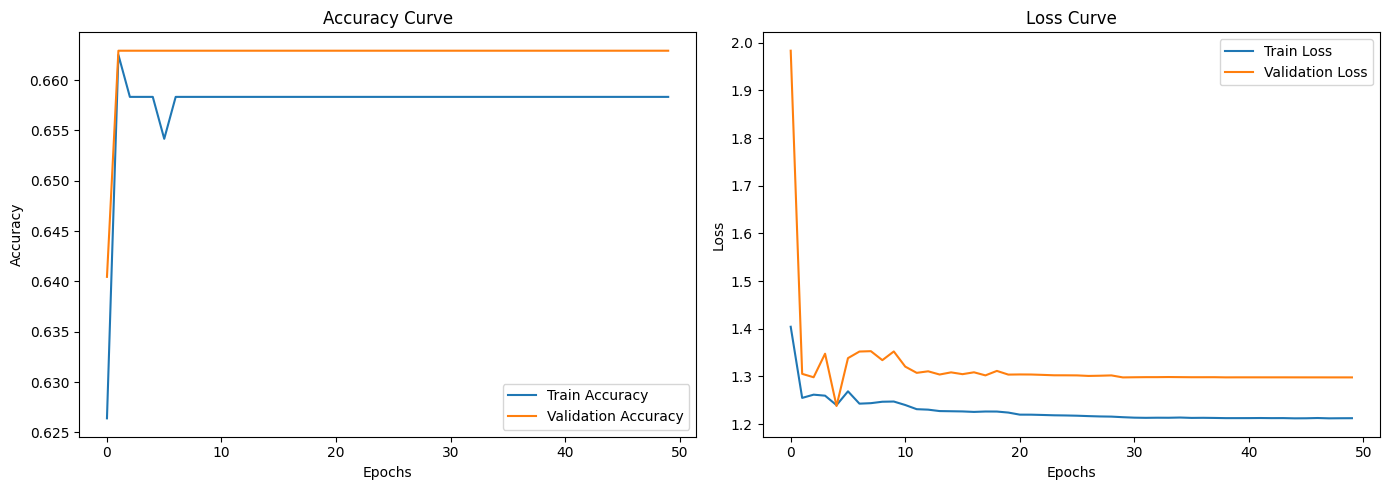

In [ ]:
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()


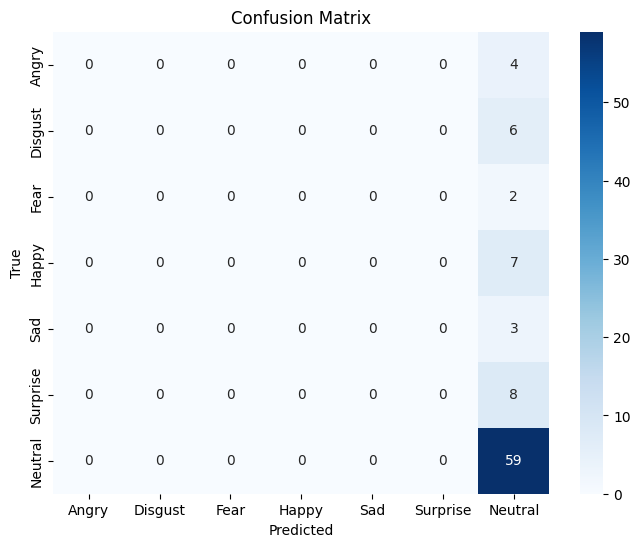

              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00         4
     Disgust       0.00      0.00      0.00         6
        Fear       0.00      0.00      0.00         2
       Happy       0.00      0.00      0.00         7
         Sad       0.00      0.00      0.00         3
    Surprise       0.00      0.00      0.00         8
     Neutral       0.66      1.00      0.80        59

    accuracy                           0.66        89
   macro avg       0.09      0.14      0.11        89
weighted avg       0.44      0.66      0.53        89



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Make predictions
all_preds = []
all_labels = []

model_4.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_4(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=emotion_labels))

**Model-5:ConvNeXt**

In [ ]:
import torch
import torch.nn as nn
import timm  # pip install timm

# ---------------------------------------------
# ✅ Pretrained ConvNeXt for CK+ (7 classes)
# ---------------------------------------------
class ConvNeXt_CK_Preload(nn.Module):
    def __init__(self, num_classes=7):
        super(ConvNeXt_CK_Preload, self).__init__()

        # 1️⃣ Load pretrained ConvNeXt (tiny variant recommended)
        self.backbone = timm.create_model(
            "convnext_tiny.fb_in22k_ft_in1k",  # You can also try: convnext_small.in12k_ft_in1k
            pretrained=True,
            in_chans=3  # pretrained weights expect RGB images
        )

        # 2️⃣ Replace classifier head
        in_features = self.backbone.head.fc.in_features
        self.backbone.head.fc = nn.Identity()  # remove default head

        # 3️⃣ Add custom classification head for CK+
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output


In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # 1 → 3 channels
    transforms.Resize((224, 224)),                # ConvNeXt input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Ensure 3 channels for validation as well
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [ ]:
import torch.optim as optim

model_5 = ConvNeXt_CK_Preload(num_classes=7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_5.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_5.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
train_dataset = FER2013Dataset("/content/drive/MyDrive/FER2013/ckextended.csv", usage='Training', transform=train_transforms)
val_dataset = FER2013Dataset("/content/drive/MyDrive/FER2013/ckextended.csv", usage='PublicTest', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

criterion = nn.CrossEntropyLoss()

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(50):
    train_loss, train_acc = train(model_5, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model_5, val_loader, criterion)

    # Append metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}")

Epoch 1: Train Acc=0.71, Val Acc=0.81
Epoch 2: Train Acc=0.88, Val Acc=0.82
Epoch 3: Train Acc=0.94, Val Acc=0.91
Epoch 4: Train Acc=0.95, Val Acc=0.88
Epoch 5: Train Acc=0.97, Val Acc=0.91
Epoch 6: Train Acc=0.98, Val Acc=0.93
Epoch 7: Train Acc=1.00, Val Acc=0.92
Epoch 8: Train Acc=1.00, Val Acc=0.92
Epoch 9: Train Acc=1.00, Val Acc=0.92
Epoch 10: Train Acc=1.00, Val Acc=0.92
Epoch 11: Train Acc=1.00, Val Acc=0.92
Epoch 12: Train Acc=1.00, Val Acc=0.92
Epoch 13: Train Acc=1.00, Val Acc=0.92
Epoch 14: Train Acc=1.00, Val Acc=0.92
Epoch 15: Train Acc=1.00, Val Acc=0.92
Epoch 16: Train Acc=1.00, Val Acc=0.92
Epoch 17: Train Acc=1.00, Val Acc=0.93
Epoch 18: Train Acc=1.00, Val Acc=0.93
Epoch 19: Train Acc=1.00, Val Acc=0.92
Epoch 20: Train Acc=1.00, Val Acc=0.93
Epoch 21: Train Acc=1.00, Val Acc=0.92
Epoch 22: Train Acc=0.97, Val Acc=0.89
Epoch 23: Train Acc=0.98, Val Acc=0.90
Epoch 24: Train Acc=0.99, Val Acc=0.91
Epoch 25: Train Acc=1.00, Val Acc=0.93
Epoch 26: Train Acc=1.00, Val Acc=

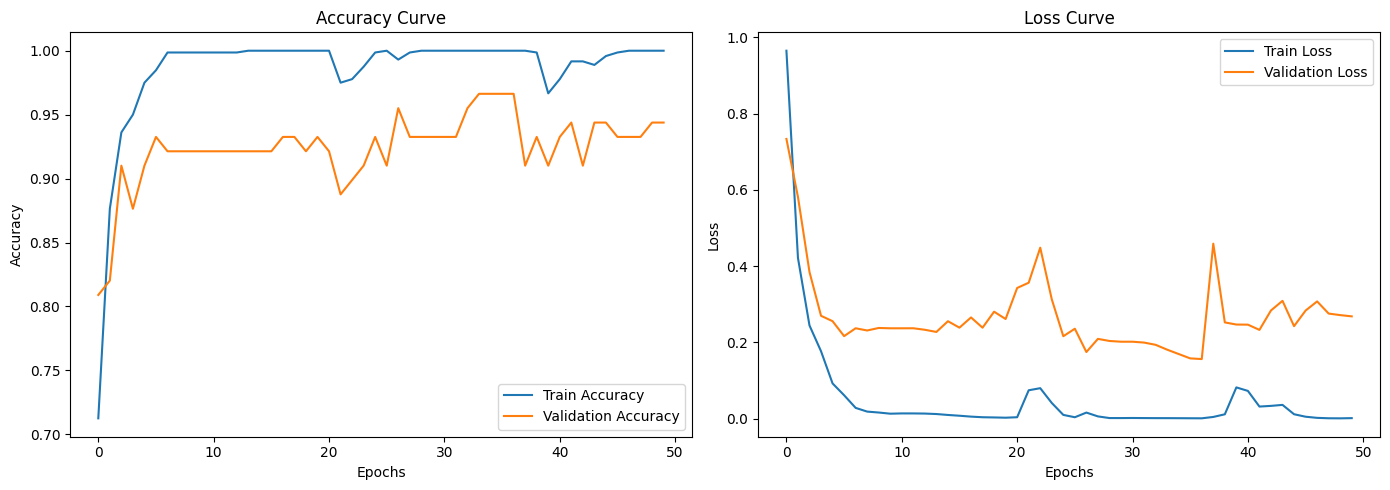

In [ ]:
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()


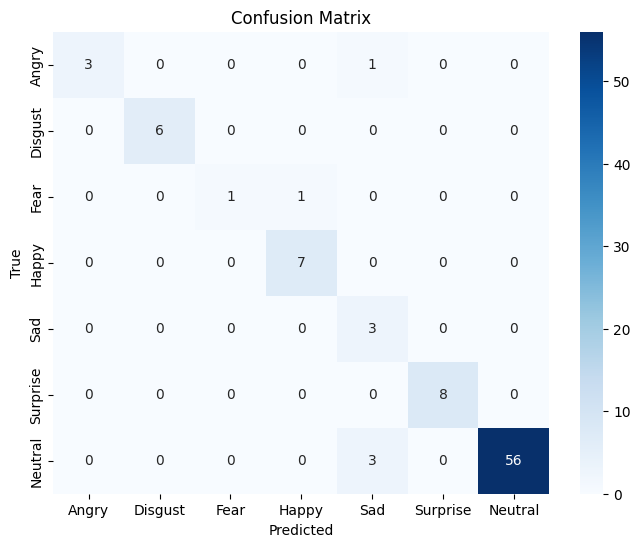

              precision    recall  f1-score   support

       Angry       1.00      0.75      0.86         4
     Disgust       1.00      1.00      1.00         6
        Fear       1.00      0.50      0.67         2
       Happy       0.88      1.00      0.93         7
         Sad       0.43      1.00      0.60         3
    Surprise       1.00      1.00      1.00         8
     Neutral       1.00      0.95      0.97        59

    accuracy                           0.94        89
   macro avg       0.90      0.89      0.86        89
weighted avg       0.97      0.94      0.95        89



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Make predictions
all_preds = []
all_labels = []

model_5.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_5(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=emotion_labels))